In [1]:
using PyPlot

In [2]:
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = zeros(N*K,D) # data matrix (each row = single example)
y = zeros(Int64, N*K) # class labels
for j in range(1,K)
    idx = range(1+N*(j-1), N); #index for X and Y
    r = linspace(0.0,1,N); # radius
    t = linspace((j-1)*4,(j)*4,N) + randn(N)*0.2 # theta
    X[idx,:] = [r.*sin(t) r.*cos(t)]
    y[idx] = j;
end

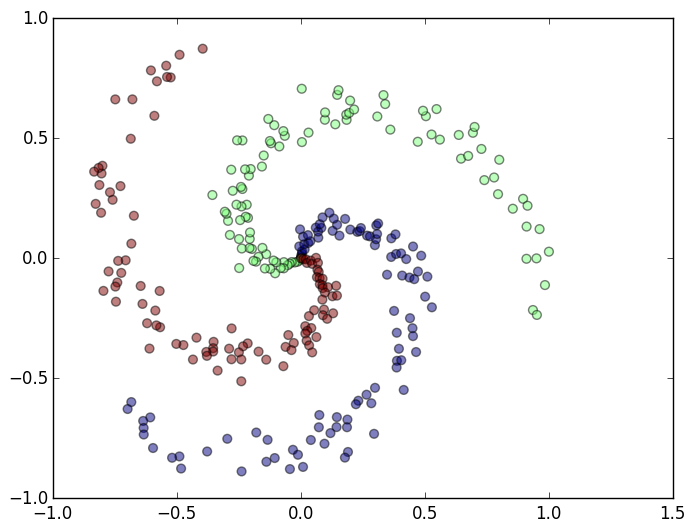

PyObject <matplotlib.collections.PathCollection object at 0x0000000029E28C88>

In [3]:
# lets visualize the data:
scatter(X[:, 1], X[:, 2], s=40, c=y, alpha=0.5)

In [4]:
# initialize parameters randomly
W = 0.01 * randn(D,K)
b = zeros((1,K))

1x3 Array{Float64,2}:
 0.0  0.0  0.0

In [5]:
# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

0.001

In [6]:
num_examples = size(X,1)

300

array probs of size [300 x 3], where each row now contains the class probabilities. In particular, since we've normalized them every row now sums to one. We can now query for the log probabilities assigned to the correct classes in each example:
```
corect_logprobs = -np.log(probs[range(num_examples),y])
```
The array correct_logprobs is a 1D array of just the probabilities assigned to the correct classes for each example. The full loss is then the average of these log probabilities and the regularization loss:

```
compute the loss: average cross-entropy loss and regularization
data_loss = np.sum(corect_logprobs)/num_examples
reg_loss = 0.5*reg*np.sum(W*W)
loss = data_loss + reg_loss
```

in this example lets use the cross-entropy loss that is associated with the Softmax classifier. Recall that if f is the array of class scores for a single example (e.g. array of 3 numbers here), then the Softmax classifier computes the loss for that example as:

$$ L_i = -\log\left(\frac{e^{f_{y_i}}}{ \sum_j e^{f_j} }\right) $$

We can see that the Softmax classifier interprets every element of f as holding the (unnormalized) log probabilities of the three classes. We exponentiate these to get (unnormalized) probabilities, and then normalize them to get probabilites. Therefore, the expression inside the log is the normalized probability of the correct class. Note how this expression works: this quantity is always between 0 and 1. When the probability of the correct class is very small (near 0), the loss will go towards (postiive) infinity. Conversely, when the correct class probability goes towards 1, the loss will go towards zero because log(1)=0. Hence, the expression for Li is low when the correct class probability is high, and it's very high when it is low.

Recall also that the full Softmax classifier loss is then defined as the average cross-entropy loss over the training examples and the regularization:

$$L =  \underbrace{ \frac{1}{N} \sum_i L_i }_\text{data loss} + \underbrace{ \frac{1}{2} \lambda \sum_k\sum_l W_{k,l}^2 }_\text{regularization loss} \\$$

 The loss for one example is:

$$p_k = \frac{e^{f_k}}{ \sum_j e^{f_j} } \hspace{1in} L_i =-\log\left(p_{y_i}\right)$$
We now wish to understand how the computed scores inside $f$ should change to decrease the loss $L_i$ that this example contributes to the full objective. In other words, we want to derive the gradient $\partial L_i / \partial f_k$. The loss $L_i$ is computed from $p$, which in turn depends on $f$. It's a fun exercise to the reader to use the chain rule to derive the gradient, but it turns out to be extremely simple and interpretible in the end, after a lot of things cancel out:

$$\frac{\partial L_i }{ \partial f_k } = p_k - 1(y_i = k)$$
Notice how elegant and simple this expression is. Suppose the probabilities we computed were p = [0.2, 0.3, 0.5], and that the correct class was the middle one (with probability 0.3). According to this derivation the gradient on the scores would be df = [0.2, -0.7, 0.5]. Recalling what the interpretation of the gradient, we see that this result is highly intuitive: increasing the first or last element of the score vector $f$ (the scores of the incorrect classes) leads to an increased loss (due to the positive signs +0.2 and +0.5) - and increasing the loss is bad, as expected. However, increasing the score of the correct class has negative influence on the loss. The gradient of -0.7 is telling us that increasing the correct class score would lead to a decrease of the loss $L_i$, which makes sense.

In [7]:
# gradient descent loop
for i in 1:200
    # compute class scores for a linear classifier
    scores =X*W .+ b;
    # compute unnormalized class probabilities
    exp_scores = exp(scores)
    # normalize them for each example
    probs = exp_scores./sum(exp_scores,2)
    corect_logprobs = zeros(num_examples)
    for j in 1:num_examples
        corect_logprobs[j] = -log(probs[j,y[j]]);
    end
    # compute the loss/cost: average cross-entropy loss and regularization
    data_loss = sum(corect_logprobs)/(num_examples)
    reg_loss = 0.5*reg*sum(W.^2)
    loss = data_loss + reg_loss
    if i % 10 == 0
        println("iteration: ", i, " loss: ", loss);
    end
    # compute the gradient on scores
    dscores = probs
    for j in 1:num_examples
        dscores[j, y[j]] = dscores[j,y[j]]-1;
    end
    dscores /= num_examples
    # backpropate the gradient to the parameters (W,b)
    dW = X'*dscores
    db = sum(dscores, 1)
    dW += reg*W # regularized gradient
    # perform a parameter update
    W += -step_size * dW
    b += -step_size * db
end

iteration: 10 loss: 0.9094609952697116
iteration: 20 loss: 0.8290964884144244
iteration: 30 loss: 0.7929583693942344
iteration: 40 loss: 0.7742122962090895
iteration: 50 loss: 0.7635448309379416
iteration: 60 loss: 0.7570814715029309
iteration: 70 loss: 0.75298685998485
iteration: 80 loss: 0.7503060412973976
iteration: 90 loss: 0.7485062772271247
iteration: 100 loss: 0.7472741314341721
iteration: 110 loss: 0.7464173634287613
iteration: 120 loss: 0.7458140922995655
iteration: 130 loss: 0.7453849433039854
iteration: 140 loss: 0.7450770737083695
iteration: 150 loss: 0.7448546572675695
iteration: 160 loss: 0.7446930323631769
iteration: 170 loss: 0.744575004532647
iteration: 180 loss: 0.7444884555835629
iteration: 190 loss: 0.7444247665391428
iteration: 200 loss: 0.7443777593892238


In [8]:
# evaluate training set accuracy
scores = X*W .+ b

predicted_class = zeros(length(scores))
for i in 1:size(scores,1)
    predicted_class[i] = indmax(scores[i,:])
end
correct = 0;
for i in 1:length(y)
    if y[i] == predicted_class[i]
        correct = correct + 1;
    end
end
println("training accuracy: ", correct/length(y))

training accuracy: 0.52


In [9]:
# plot the resulting classifier
h = 0.02;
x_min = minimum(X[:, 1]) - 1;
x_max = maximum(X[:, 1]) + 1;
y_min = minimum(X[:, 2]) - 1;
y_max = maximum(X[:, 2]) + 1;
numX = convert(Int, floor((x_max - x_min)/h));
xx = zeros(numX);
xx[1] = x_min;
yy = zeros(numX);
yy[1] = y_min;
for i in 2:numX
    xx[i] = xx[i-1] + h;
    yy[i] = yy[i-1] + h;
end
grid_x = [i for i in xx, j in yy];
grid_y = [j for i in xx, j in yy];
xy = [grid_x[:] grid_y[:]];
z = xy*W .+ b;
zz = zeros(size(z,1));
for i in 1:size(z,1)
    zz[i] = indmax(z[i,:])
end
zz = reshape(zz, size(grid_x));

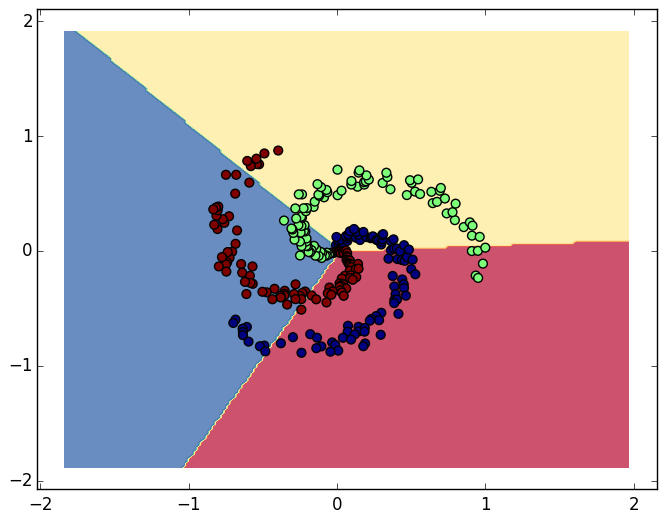

PyObject <matplotlib.collections.PathCollection object at 0x000000002A32FF98>

In [10]:
contourf(grid_x, grid_y, zz, cmap=get_cmap("Spectral"), alpha=0.8) 
scatter(X[:, 1], X[:, 2], c=y, s=40)